In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns

In [2]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
DRIVER_GENES = "../data/driver_genes"
PANGOLIN_PREDICTIONS = "../data/pangolin_predictions"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"
GENE_NAME_MAPPING = "../data/ref/gene_mappings.tsv"

# output files/dir
SPLICING_CHANGES = "../results/splicing_changes"
os.makedirs(SPLICING_CHANGES, exist_ok=True)
PLOT_DATA_DIR = "../plot_data/splicing_pangolin/cancer_type_specific"
os.makedirs(PLOT_DATA_DIR, exist_ok=True)

In [3]:
cancer_type ="Prost-AdenoCA"

In [4]:
gene_names = pd.read_csv(GENE_NAME_MAPPING, sep="\t")
# dictionary to map ensemble gene id to gene name
gene_dict = dict(zip(gene_names["ensembl_gene_id"], gene_names["hgnc_symbol"]))
print(len(gene_dict))

70611


In [5]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [6]:
# get pangolin prediction
pangolin_df = pd.read_csv(f"{PANGOLIN_PREDICTIONS}/{cancer_type}_pred.csv", sep="\t")
pangolin_df.columns = ["data"]
pangolin_df["mutation_loc"] = pangolin_df["data"].apply(lambda x: ':'.join(x.split(",")[:4]))
pangolin_df["scores"] = pangolin_df["data"].apply(lambda x: x.split(",")[4:])
pangolin_df = pangolin_df.drop(columns=["data"])
print(pangolin_df.shape)

# separate rows for scores for multiple genes
pangolin_df = pangolin_df.explode("scores")
print(pangolin_df.shape)

# drop rows with no scores
pangolin_df = pangolin_df[pangolin_df["scores"] != ""]
print(pangolin_df.shape)

# display warnings if any, clean up the data
pangolin_df["warning"] = pangolin_df["scores"].apply(lambda x: x.split("|Warnings:")[1] if "|Warnings:" in x else "")
pangolin_df["scores"] = pangolin_df["scores"].apply(lambda x: x.split("|Warnings:")[0])
warnings = pangolin_df[pangolin_df["warning"] != ""]["warning"].tolist()
if warnings:
	print(f"Warnings: {warnings}")
pangolin_df.drop(columns=["warning"], inplace=True)

# parse gene and scores
pangolin_df["splice_gene_id"] = pangolin_df["scores"].apply(lambda x: x.split("|")[0])
pangolin_df["scores"] = pangolin_df["scores"].apply(lambda x: x.split("|")[1:])
pangolin_df = pangolin_df.explode("scores")
pangolin_df["splice_pos"] = pangolin_df["scores"].apply(lambda x: x.split(":")[0]) # relative position
pangolin_df["splice_score"] = pangolin_df["scores"].apply(lambda x: x.split(":")[1])
pangolin_df.drop(columns=["scores"], inplace=True)
print(pangolin_df.shape)

# pangolin paper mentions that at a cut-off of 0.14, false sign rate is 5%
pangolin_df["splice_score"] = pangolin_df["splice_score"].astype(float)
pangolin_df = pangolin_df[abs(pangolin_df["splice_score"]) > 0.14]
print(pangolin_df.shape)

# get hgnc gene names
pangolin_df["splice_gene"] = pangolin_df["splice_gene_id"].apply(lambda x: \
									gene_dict[x.split('.')[0]] if x.split('.')[0] in gene_dict else None)
pangolin_df.drop(columns=["splice_gene_id"], inplace=True)

# splicing changes in the format gene:pos:score for each mutation
pangolin_df["splice_change"] = pangolin_df.apply(lambda x: f"{x['splice_gene']}:{x['splice_pos']}:{x['splice_score']}", axis=1)
pangolin_df.drop(columns=["splice_gene", "splice_pos", "splice_score"], inplace=True)
pangolin_df = pangolin_df.groupby(["mutation_loc"])["splice_change"].apply(lambda x: list(x)).reset_index()
print(pangolin_df.shape)

(2257, 2)
(2295, 2)
(2281, 2)
Warnings: ['NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene']
(4562, 4)
(35, 4)
(28, 2)


In [7]:
# get all mutations in driver genes
mut_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
driver_genes_list = driver_genes["gene"].tolist()
mut_df = mut_df[mut_df["gene"].isin(driver_genes_list)]
mut_df = mut_df[["Tumor_Sample_Barcode", "gene", "has_driver", "driver", "mutation_loc", "genic_region"]]
print(mut_df.shape)
mut_df = pd.merge(mut_df, pangolin_df, on="mutation_loc", how="left")
print(mut_df.shape)
mut_df = mut_df.explode("splice_change")
print(mut_df.shape)

# get driver status
mut_df["driver_status"] = mut_df.apply(lambda x: "Passengers in presence of driver" if x["has_driver"] else "Passengers in absence of driver", axis=1)
mut_df["driver_status"] = mut_df.apply(lambda x: "Drivers" if x["driver"] else x["driver_status"], axis=1)
print(mut_df.shape)

# filter out samples that are not in the whitelist
mut_df = mut_df[mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(mut_df.shape)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_5544/2509081111.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")


(3412, 6)
(3412, 7)
(3419, 7)
(3419, 8)
(2095, 8)


In [8]:
plot_df = mut_df[["mutation_loc", "driver_status", "gene", "splice_change", "driver"]]
print(plot_df.shape)
num_mutations = plot_df.shape[0]
print("No. of mutations:", num_mutations)

plot_df.dropna(subset=["splice_change"], inplace=True)
print(plot_df.shape)
plot_df = plot_df.groupby(["splice_change", "mutation_loc", "driver_status", "driver", "gene"]).size().reset_index(name="count")
plot_df["pos"] = plot_df["splice_change"].apply(lambda x: int(x.split(":")[1]))
plot_df["splice_gene"] = plot_df["splice_change"].apply(lambda x: x.split(":")[0])
plot_df["score"] = plot_df["splice_change"].apply(lambda x: float(x.split(":")[2]))
plot_df["marker_size"] = plot_df["count"] * 200
print(plot_df.shape)

(2095, 5)
No. of mutations: 2095
(30, 5)
(30, 10)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_5544/3751066378.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.dropna(subset=["splice_change"], inplace=True)


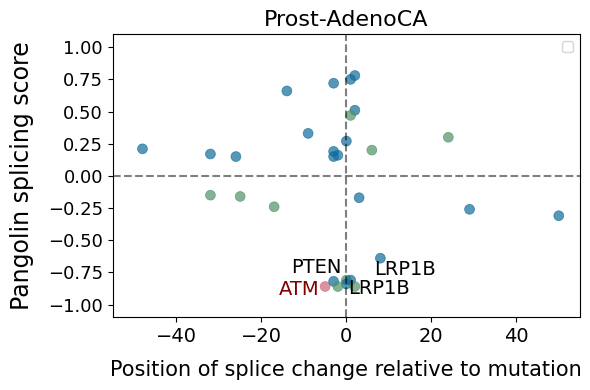

In [9]:
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
plt.figure(figsize=(6, 4))
hue_order = ["Passengers in presence of driver", "Passengers in absence of driver", "Drivers"]
# add gene annotations
sns.scatterplot(
    x="pos", 
    y="score", 
    palette=cmap,
    hue="driver_status", 
	size="count",
	sizes=(50, 150),
	hue_order=hue_order,
    data=plot_df,
    alpha=0.7,
    edgecolor=None,
	legend=False
)
plt.axhline(y=0, linestyle='--', color="black", alpha=0.5)
plt.axvline(x=0, linestyle='--', color="black", alpha=0.5)
# annotate passenger mutations that cause big splicing changes (>= 50% change in probablity)
# avoid overlapping text
splice_annot = []
for index, row in plot_df.iterrows():
	color = 'black' if row["driver_status"] == "Passengers in absence of driver" else 'maroon'
	if row["score"] >= 0.8 and row["driver"] == False:
		splice_annot.append(plt.text(row["pos"], row["score"], row["gene"], fontsize=14, ha='center', va='bottom', color=color))
	elif row["score"] <= -0.8 and row["driver"] == False:
		splice_annot.append(plt.text(row["pos"], row["score"], row["gene"], fontsize=14, ha='center', va='top', color=color))
adjust_text(splice_annot)

# formatting
plt.xlim(-55, 55)
plt.ylim(-1.1, 1.1)
plt.xticks(fontsize=14)
plt.xlabel("Position of splice change relative to mutation", fontsize=15, labelpad=10)
plt.yticks(fontsize=13)
plt.ylabel("Pangolin splicing score", fontsize=17, labelpad=10)
plt.title(cancer_type, fontsize=16)
plt.legend([])

plt.tight_layout()
plt.savefig(f"{SPLICING_CHANGES}/{cancer_type}.png")

# source data
plot_df[["pos", "score", "driver_status", "count", "gene", "splice_gene"]].to_csv(f"{PLOT_DATA_DIR}/{cancer_type}_splicing_changes.tsv", sep="\t", index=False)